In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
sns.set() #formato ggplot a las gráficas
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# classifier imports
from sklearn.neural_network import MLPClassifier

# Lectura de datos

In [2]:
Train_df = pd.read_csv('./train.csv')
Test_df = pd.read_csv('./test.csv')
test_y = pd.read_csv('./test_labels.csv')
Test_df=pd.merge(Test_df, test_y, on=['id', 'id'])

In [3]:
Train_df.rename(columns={'obscene':'obscenidad','insult':'insulto','toxic':'toxico','severe_toxic':'severamente_toxico','identity_hate':'discurso_odio','threat':'amenaza'},inplace=True)
Test_df.rename(columns={'obscene':'obscenidad','insult':'insulto','toxic':'toxico','severe_toxic':'severamente_toxico','identity_hate':'discurso_odio','threat':'amenaza'},inplace=True)
Test_df = Test_df[Test_df.toxico!=-1]

In [4]:
# vector con el nombre de las etiquetas
etiquetas = ['obscenidad','insulto','toxico','severamente_toxico','discurso_odio','amenaza']

In [5]:
#crear variables para hacer un poco  de análisis descriptivo
Train_df['numero_etiquetas'] = Train_df[etiquetas].sum(axis=1)
Train_df['Longitud_Mensaje'] = Train_df['comment_text'].apply(lambda x: len(str(x)))

## Descripcción

[Text(0.5, 1.0, 'Histograma longitud de los mensajes')]

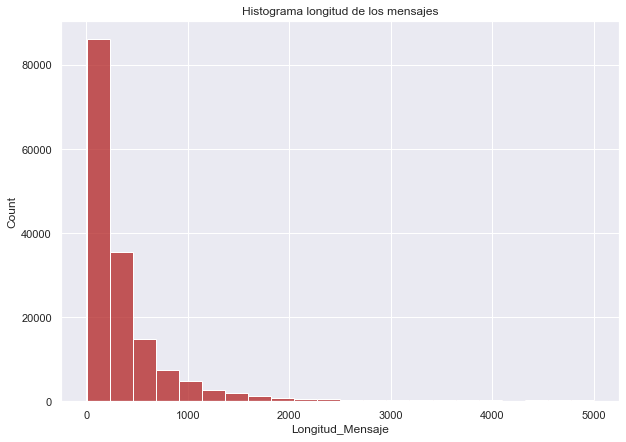

In [6]:

fig = plt.figure(figsize = (10,7))
ax=sns.histplot(data = Train_df, x = 'Longitud_Mensaje',bins=22,color='firebrick')
ax.set( title='Histograma longitud de los mensajes')

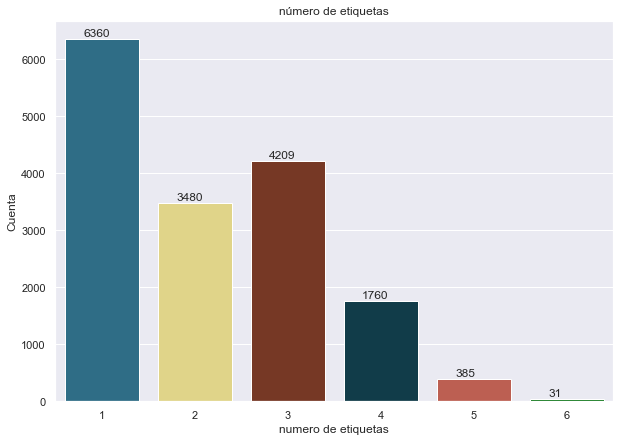

In [7]:

fig = plt.figure(figsize = (10,7))
ax = sns.countplot(data = Train_df[Train_df.numero_etiquetas>0], x = 'numero_etiquetas',
palette=['#207394','#eede7b', '#833118','#084152','#cd5241','#028A0F'])
ax.set( xlabel = "numero de etiquetas", ylabel = "Cuenta",title='número de etiquetas')
for p in ax.patches:
        ax.annotate('{:d}'.format(p.get_height()), (p.get_x()+0.2, p.get_height()+50))

In [8]:
Train_df[Train_df.numero_etiquetas >1].head(1)

,id,comment_text,toxico,severamente_toxico,obscenidad,amenaza,insulto,discurso_odio,numero_etiquetas,Longitud_Mensaje
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,4,44


Hay mensajes que pueden tener más de una etiqueta o no tener ninguna etiqueta.

In [9]:
sin_etiqueta = Train_df[(Train_df['toxico']!=1) & (Train_df['severamente_toxico']!=1) & (Train_df['obscenidad']!=1) & 
                            (Train_df['amenaza']!=1) & (Train_df['insulto']!=1) & (Train_df['discurso_odio']!=1)]
print('El Porcentaje de comentario sin etiqueta en el set de entremaniemto es', len(sin_etiqueta)/len(Train_df)*100)

El Porcentaje de comentario sin etiqueta en el set de entremaniemto es 89.83211235124176


In [10]:

print('Se cuentan con ', Train_df.shape[0], ' comentarios en los datos de entrenamiento')
print('Se cuentan con ',Test_df.shape[0], ' comentarios en los datos de testeo')
print(Train_df[etiquetas].sum())

Se cuentan con  159571  comentarios en los datos de entrenamiento
Se cuentan con  63978  comentarios en los datos de testeo
obscenidad             8449
insulto                7877
toxico                15294
severamente_toxico     1595
discurso_odio          1405
amenaza                 478
dtype: int64


[Text(0.5, 1.0, 'Número de comentarios por etiqueta'),
 Text(0, 0.5, 'Cuenta'),
 Text(0.5, 0, 'tipo etiqueta')]

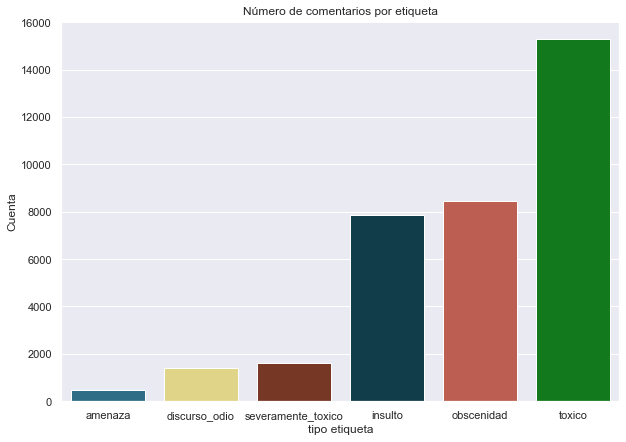

In [11]:
d = pd.DataFrame( Train_df[etiquetas].sum())
d = d.reset_index()
d =d.rename(columns={'index':'Etiqueta', 0:'Cuenta'})

fig = plt.figure(figsize = (10,7))
ax = sns.barplot(data =d, x = 'Etiqueta', y = 'Cuenta', 
palette=['#207394','#eede7b', '#833118','#084152','#cd5241','#028A0F'],order =['amenaza','discurso_odio','severamente_toxico', 'insulto', 'obscenidad', 'toxico'])
ax.set( title = "Número de comentarios por etiqueta", ylabel = "Cuenta",xlabel='tipo etiqueta')

In [12]:
## Preprocesamiento

In [13]:
def preprocesamiento(comentario):
    comentario = comentario.lower()
    comentario = re.sub(r"what's", "what is ", comentario)
    comentario = re.sub(r"\'s", " ", comentario)
    comentario = re.sub(r"\'ve", " have ", comentario)
    comentario = re.sub(r"can't", "cannot ", comentario)
    comentario = re.sub(r"n't", " not ", comentario)
    comentario = re.sub(r"i'm", "i am ", comentario)
    comentario = re.sub(r"\'re", " are ", comentario)
    comentario = re.sub(r"\'d", " would ", comentario)
    comentario = re.sub(r"\'ll", " will ", comentario)
    comentario = re.sub(r"\'scuse", " excuse ", comentario)
    comentario = re.sub('\W', ' ', comentario)
    comentario = re.sub('\s+', ' ', comentario)
    comentario = comentario.strip(' ')
    return comentario

In [14]:

#Entrenamiento
Train_df['comment_text'] = Train_df['comment_text'].map(lambda com: preprocesamiento(com))
Test_df['comment_text'] = Test_df['comment_text'].map(lambda com: preprocesamiento(com))
Train_df = Train_df.drop(['numero_etiquetas','Longitud_Mensaje'], axis = 1 )

In [15]:
Train_X = Train_df.comment_text
Test_X = Test_df.comment_text

In [16]:
print(Test_X.shape)
print(Train_X.shape)

(63978,)
(159571,)


In [17]:
vectorizador_TFIDF =  TfidfVectorizer(max_features=5000,stop_words='english')

In [18]:
X_dtm= vectorizador_TFIDF.fit_transform(Train_X)
X_dtm

<159571x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 3178792 stored elements in Compressed Sparse Row format>

In [19]:
test_X_dtm = vectorizador_TFIDF.transform(Test_X)
test_X_dtm

<63978x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 1153628 stored elements in Compressed Sparse Row format>

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
logreg = LogisticRegression(C=12.0)

In [21]:
from plot_metric.functions import BinaryClassification

obscenidad


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


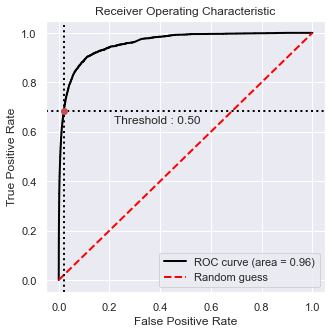

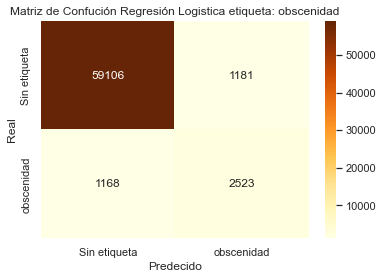

Accuracy is 0.9632842539622996
AUC is 0.9594274729865363
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     60287
           1       0.68      0.68      0.68      3691

    accuracy                           0.96     63978
   macro avg       0.83      0.83      0.83     63978
weighted avg       0.96      0.96      0.96     63978

insulto


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


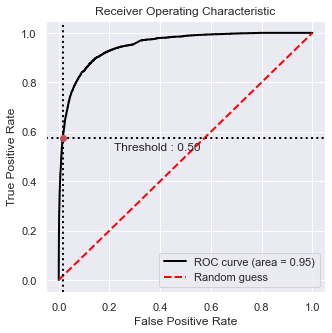

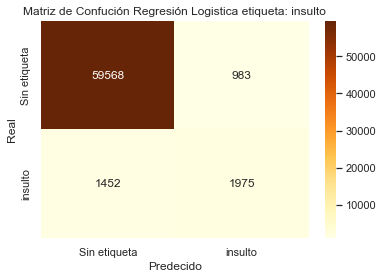

Accuracy is 0.9619400418893995
AUC is 0.9485576616300467
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     60551
           1       0.67      0.58      0.62      3427

    accuracy                           0.96     63978
   macro avg       0.82      0.78      0.80     63978
weighted avg       0.96      0.96      0.96     63978

toxico


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


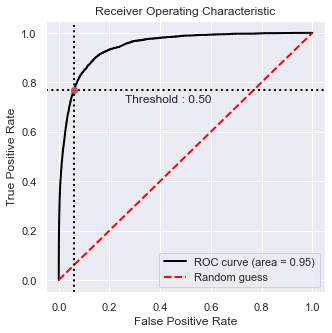

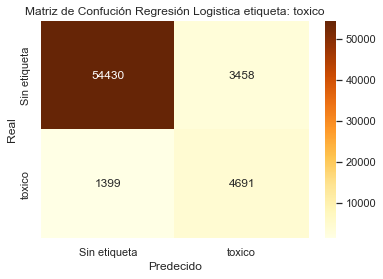

Accuracy is 0.924083278627028
AUC is 0.9471338232210595
              precision    recall  f1-score   support

           0       0.97      0.94      0.96     57888
           1       0.58      0.77      0.66      6090

    accuracy                           0.92     63978
   macro avg       0.78      0.86      0.81     63978
weighted avg       0.94      0.92      0.93     63978

severamente_toxico


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


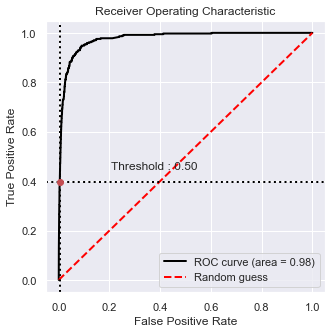

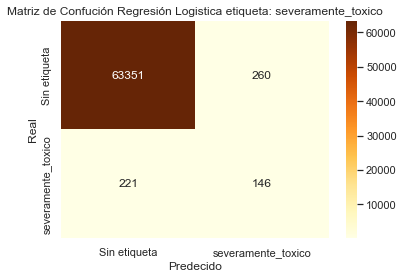

Accuracy is 0.9924817906155241
AUC is 0.9769021406807736
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63611
           1       0.36      0.40      0.38       367

    accuracy                           0.99     63978
   macro avg       0.68      0.70      0.69     63978
weighted avg       0.99      0.99      0.99     63978

discurso_odio


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


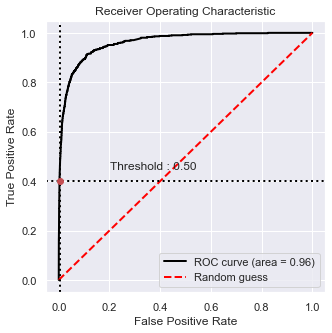

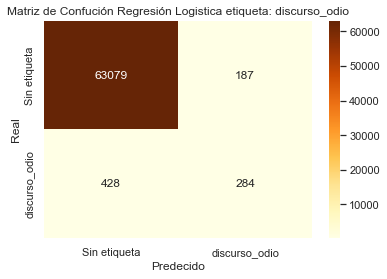

Accuracy is 0.9903873206414705
AUC is 0.9619152831437232
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63266
           1       0.60      0.40      0.48       712

    accuracy                           0.99     63978
   macro avg       0.80      0.70      0.74     63978
weighted avg       0.99      0.99      0.99     63978

amenaza


c:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


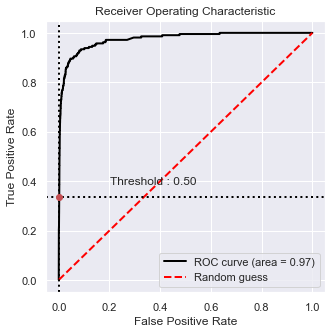

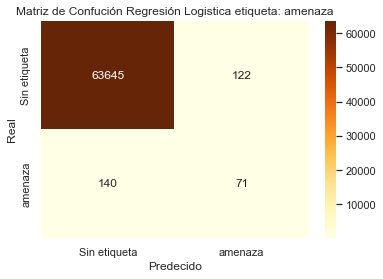

Accuracy is 0.995904842289537
AUC is 0.974515521815686
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.37      0.34      0.35       211

    accuracy                           1.00     63978
   macro avg       0.68      0.67      0.67     63978
weighted avg       1.00      1.00      1.00     63978



In [22]:
accuracy_list = []
auc_list = []

for etiqueta in etiquetas:
    print(etiqueta)
    y = Train_df[etiqueta]
    logreg.fit(X_dtm, y)
    y_pred_X = logreg.predict(test_X_dtm)
    y_test = Test_df[etiqueta]
    test_y_prob = logreg.predict_proba(test_X_dtm)[:,1]

    fpr, tpr, _ = roc_curve(y_test,  test_y_prob)

    accuracy_list.append(accuracy_score(y_test, y_pred_X))
    auc_list.append(roc_auc_score(y_test, test_y_prob))
    
    bc = BinaryClassification(y_test, test_y_prob, labels=["Class 1", "Class 2"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()


    m_LR = confusion_matrix(y_test, y_pred_X)
    sns.heatmap(m_LR,annot=True, cmap="YlOrBr", fmt="d", 
                xticklabels =["Sin etiqueta",  etiqueta], 
                yticklabels = ["Sin etiqueta",  etiqueta])
    plt.ylabel('Real')
    plt.xlabel('Predecido')
    plt.title("Matriz de Confución Regresión Logistica etiqueta: "+ str(etiqueta))
    plt.show()


    
    print('Accuracy is {}'.format(accuracy_score(y_test, y_pred_X)))
    print('AUC is {}'.format(roc_auc_score(y_test, test_y_prob)))

    print(classification_report(y_test, y_pred_X))
    

In [23]:
sum(auc_list)/len(auc_list)

0.9614086505796376

# Modelo word2Vec

In [24]:
from regex import W


stop_words = set(['all', "she'll", "don't", 'being', 'over', 'through', 
'yourselves', 'its', 'before', "he's", "when's", "we've", 'had', 'should',
"he'd", 'to', 'only', "there's", 'those', 'under', 'ours', 'has', 
"haven't", 'do', 'them', 'his', "they'll", 'very', "who's", "they'd", 
'cannot', "you've", 'they', 'not', 'during', 'yourself', 'him', 'nor', 
"we'll", 'did', "they've", 'this', 'she', 'each', "won't", 'where', 
"mustn't", "isn't", "i'll", "why's", 'because', "you'd", 'doing', 'some', 
'up', 'are', 'further', 'ourselves', 'out', 'what', 'for', 'while', 
"wasn't", 'does', "shouldn't", 'above', 'between', 'be', 'we', 'who', 
"you're", 'were', 'here', 'hers', "aren't", 'by', 'both', 'about', 'would', 
'of', 'could', 'against', "i'd", "weren't", "i'm", 'or', "can't", 'own', 
'into', 'whom', 'down', "hadn't", "couldn't", 'your', "doesn't", 'from', 
"how's", 'her', 'their', "it's", 'there', 'been', 'why', 'few', 'too', 
'themselves', 'was', 'until', 'more', 'himself', "where's", "i've", 'with', 
"didn't", "what's", 'but', 'herself', 'than', "here's", 'he', 'me', 
"they're", 'myself', 'these', "hasn't", 'below', 'ought', 'theirs', 'my', 
"wouldn't", "we'd", 'and', 'then', 'is', 'am', 'it', 'an', 'as', 'itself', 
'at', 'have', 'in', 'any', 'if', 'again', 'no', 'that', 'when', 'same', 
'how', 'other', 'which', 'you', "shan't", 'our', 'after', "let's", 'most', 
'such', 'on', "he'll", 'a', 'off', 'i', "she'd", 'yours', "you'll", 'so', 
"we're", "she's", 'the', "that's", 'having', 'once'])


#eliminar stopwords y tokenizar
def Tokenizar(mensajes):
    patron = re.compile('[\W_]+', re.UNICODE)
    mensajes_t = []
    for mensaje in mensajes:
        mensaje_t = mensaje.lower().split(" ") #separar en palabras
        mensaje_t = [patron.sub('', w) for w in mensaje_t]
        mensajes_t.append( [w for w in mensaje_t if w not in stop_words] )
    return mensajes_t

def featurize_w2v(model, sentences):
    f = np.zeros((len(sentences), model.vector_size))
    for i,s in enumerate(sentences):
        for w in s:
            try:
                vec = model.wv[W]
            except KeyError:
                continue
            f[i,:] = f[i,:] + vec
        f[i,:] = f[i,:] / len(s)
    return f

def delete_nans(features):
    rows_to_delete = []
    for i in range(len(features)):
        if np.isnan(features[i].sum()):
            rows_to_delete.append(i)
    return rows_to_delete

In [25]:
from gensim.models import word2vec

In [26]:
sentences_train = Tokenizar(Train_df.comment_text)
sentences_test =Tokenizar(Test_df.comment_text)
#lista de mensajes tokenizados
#model = Word2Vec(sentences, window=5,vector_size=700, min_count=6, sample=1e-3, workers=2)
#model = Word2Vec(sentences, vecosize=500, window=5, min_count=6, sample=1e-3, workers=2)
#model.init_sims(replace=True)

In [27]:
# Establecer el valor de los parametros para entrenar word2vec
num_caracteristicas = 700    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words
# Initialize and train the model (this will take some time)
model = word2vec.Word2Vec(sentences_train, workers=num_workers, vector_size=num_caracteristicas, min_count = min_word_count, window = context, sample = downsampling)
model.init_sims(replace=True) # marks the end of training to speed up the use of the model

<ipython-input-27-d8e2dbca465a>:9: DeprecationWarning: Call to deprecated `init_sims` (Gensim 4.0.0 implemented internal optimizations that make calls to init_sims() unnecessary. init_sims() is now obsoleted and will be completely removed in future versions. See https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4).
  model.init_sims(replace=True) # marks the end of training to speed up the use of the model


In [28]:
def makeFeatureVec(words, model, num_features):
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((num_features,), dtype="float32")
    #
    nwords = 0
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index_to_key)
    #
    # Loop over each word in the message and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1
            featureVec = np.add(featureVec,  model.wv[word])
    # Divide the result by the number of words to get the average
    if nwords == 0:
        nwords = 1
    featureVec = np.divide(featureVec, nwords)
    return featureVec

In [29]:
def getAvgFeatureVecs(messages, model, num_features):
    # Given a set of message (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # Preallocate a 2D numpy array, for speed
    messageFeatureVecs = np.zeros((len(messages), num_features), dtype="float32")
    counter = 0
    # Loop through the reviews
    for message in messages:
        # Call the function (defined above) that makes average feature vectors
        messageFeatureVecs[counter] = makeFeatureVec(message, model, num_features)
        counter = counter + 1
    return messageFeatureVecs
    


In [30]:
f_matrix_train = getAvgFeatureVecs(sentences_train, model, num_caracteristicas)
f_matrix_test = getAvgFeatureVecs(sentences_test, model, num_caracteristicas)

In [31]:
f_matrix_test.shape
f_matrix_train.shape

(159571, 700)

In [32]:
#y = [Train_df['toxico'], Train_df['severamente_toxico'], Train_df['obscenidad'], Train_df['amenaza'], Train_df['insulto'], Train_df['discurso_odio']]

In [33]:
#y[2]

In [34]:
#features_w2v = featurize_w2v(model, sentences)

In [35]:
# create 6 MLP models
model = []
for i in range(0, 6):
    m = MLPClassifier(solver='adam', hidden_layer_sizes=(15,30), random_state=1, activation='relu',verbose=True, max_iter=25)
    model.append(m)
print(model)

[MLPClassifier(hidden_layer_sizes=(15, 30), max_iter=25, random_state=1,
              verbose=True), MLPClassifier(hidden_layer_sizes=(15, 30), max_iter=25, random_state=1,
              verbose=True), MLPClassifier(hidden_layer_sizes=(15, 30), max_iter=25, random_state=1,
              verbose=True), MLPClassifier(hidden_layer_sizes=(15, 30), max_iter=25, random_state=1,
              verbose=True), MLPClassifier(hidden_layer_sizes=(15, 30), max_iter=25, random_state=1,
              verbose=True), MLPClassifier(hidden_layer_sizes=(15, 30), max_iter=25, random_state=1,
              verbose=True)]


In [36]:
#batch_size = 10000
#total_rows = f_matrix_train.shape[0]
#duration = 0

#pos = 0
#classes = [0,1]
# we use a partial fit approach

#for i in range(0,6):
#    X_p = f_matrix_train
#    y_p = y[i]
#    model[i].fit(X_p, y_p)



obscenidad
Iteration 1, loss = 0.15843935
Iteration 2, loss = 0.08104804
Iteration 3, loss = 0.07817274
Iteration 4, loss = 0.07618567
Iteration 5, loss = 0.07451102
Iteration 6, loss = 0.07328889
Iteration 7, loss = 0.07235139
Iteration 8, loss = 0.07112795
Iteration 9, loss = 0.07039683
Iteration 10, loss = 0.06962493
Iteration 11, loss = 0.06892585
Iteration 12, loss = 0.06845627
Iteration 13, loss = 0.06783597
Iteration 14, loss = 0.06722719
Iteration 15, loss = 0.06697513
Iteration 16, loss = 0.06667352
Iteration 17, loss = 0.06614724
Iteration 18, loss = 0.06565351
Iteration 19, loss = 0.06537828
Iteration 20, loss = 0.06491381
Iteration 21, loss = 0.06463101
Iteration 22, loss = 0.06459505
Iteration 23, loss = 0.06410119
Iteration 24, loss = 0.06371522
Iteration 25, loss = 0.06337193


c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


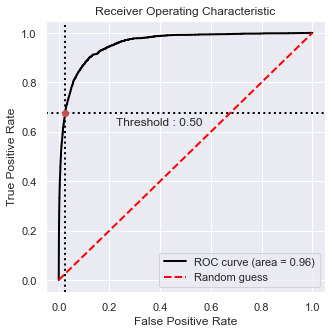

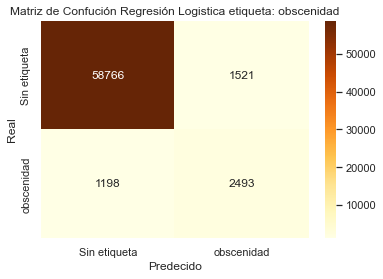

Accuracy is 0.9575010159742412
AUC is 0.9565074051526052
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     60287
           1       0.62      0.68      0.65      3691

    accuracy                           0.96     63978
   macro avg       0.80      0.83      0.81     63978
weighted avg       0.96      0.96      0.96     63978

insulto
Iteration 1, loss = 0.16141387
Iteration 2, loss = 0.08867344
Iteration 3, loss = 0.08612280
Iteration 4, loss = 0.08461445
Iteration 5, loss = 0.08350904
Iteration 6, loss = 0.08270210
Iteration 7, loss = 0.08189770
Iteration 8, loss = 0.08117007
Iteration 9, loss = 0.08056960
Iteration 10, loss = 0.08018531
Iteration 11, loss = 0.07952481
Iteration 12, loss = 0.07911125
Iteration 13, loss = 0.07852348
Iteration 14, loss = 0.07809654
Iteration 15, loss = 0.07782584
Iteration 16, loss = 0.07753702
Iteration 17, loss = 0.07703621
Iteration 18, loss = 0.07677639
Iteration 19, loss = 0.07640657
Iteration

c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


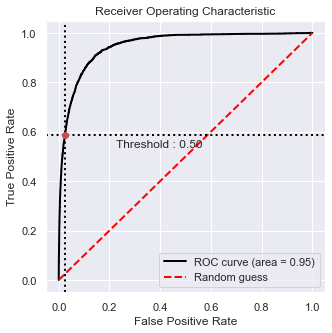

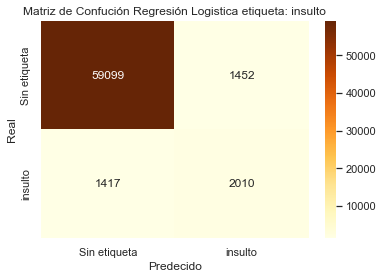

Accuracy is 0.9551564600331364
AUC is 0.9490773445147926
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     60551
           1       0.58      0.59      0.58      3427

    accuracy                           0.96     63978
   macro avg       0.78      0.78      0.78     63978
weighted avg       0.96      0.96      0.96     63978

toxico
Iteration 1, loss = 0.20806021
Iteration 2, loss = 0.13920283
Iteration 3, loss = 0.13537505
Iteration 4, loss = 0.13341633
Iteration 5, loss = 0.13202852
Iteration 6, loss = 0.13096179
Iteration 7, loss = 0.12973936
Iteration 8, loss = 0.12886004
Iteration 9, loss = 0.12787294
Iteration 10, loss = 0.12728652
Iteration 11, loss = 0.12642148
Iteration 12, loss = 0.12564890
Iteration 13, loss = 0.12499741
Iteration 14, loss = 0.12438937
Iteration 15, loss = 0.12400428
Iteration 16, loss = 0.12320704
Iteration 17, loss = 0.12291379
Iteration 18, loss = 0.12220872
Iteration 19, loss = 0.12190842
Iteration 

c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


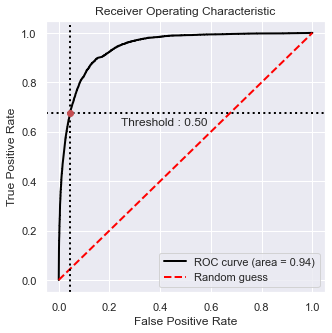

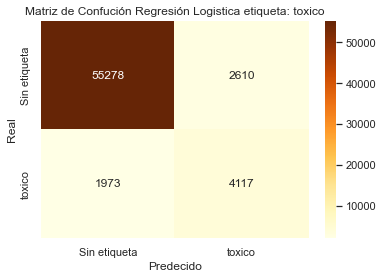

Accuracy is 0.9283660008127794
AUC is 0.9430352244093345
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     57888
           1       0.61      0.68      0.64      6090

    accuracy                           0.93     63978
   macro avg       0.79      0.82      0.80     63978
weighted avg       0.93      0.93      0.93     63978

severamente_toxico
Iteration 1, loss = 0.09925135
Iteration 2, loss = 0.02667862
Iteration 3, loss = 0.02554663
Iteration 4, loss = 0.02494995
Iteration 5, loss = 0.02456036
Iteration 6, loss = 0.02416378
Iteration 7, loss = 0.02389263
Iteration 8, loss = 0.02363209
Iteration 9, loss = 0.02334565
Iteration 10, loss = 0.02308976
Iteration 11, loss = 0.02288140
Iteration 12, loss = 0.02265989
Iteration 13, loss = 0.02244764
Iteration 14, loss = 0.02228061
Iteration 15, loss = 0.02207169
Iteration 16, loss = 0.02185803
Iteration 17, loss = 0.02183195
Iteration 18, loss = 0.02159110
Iteration 19, loss = 0.0214903

c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


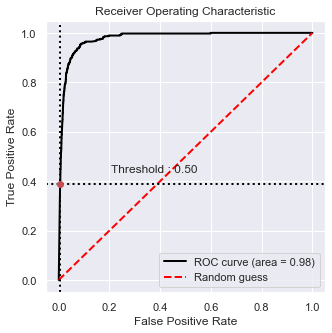

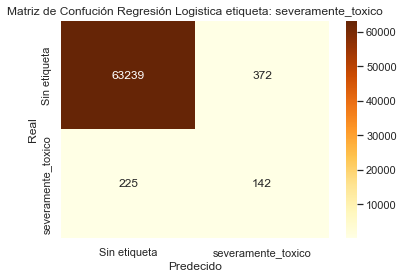

Accuracy is 0.9906686673544031
AUC is 0.9778145109428531
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     63611
           1       0.28      0.39      0.32       367

    accuracy                           0.99     63978
   macro avg       0.64      0.69      0.66     63978
weighted avg       0.99      0.99      0.99     63978

discurso_odio
Iteration 1, loss = 0.10011832
Iteration 2, loss = 0.02861862
Iteration 3, loss = 0.02708807
Iteration 4, loss = 0.02614455
Iteration 5, loss = 0.02532681
Iteration 6, loss = 0.02468013
Iteration 7, loss = 0.02421788
Iteration 8, loss = 0.02379793
Iteration 9, loss = 0.02340958
Iteration 10, loss = 0.02307195
Iteration 11, loss = 0.02274153
Iteration 12, loss = 0.02253801
Iteration 13, loss = 0.02218341
Iteration 14, loss = 0.02196863
Iteration 15, loss = 0.02175128
Iteration 16, loss = 0.02153527
Iteration 17, loss = 0.02134045
Iteration 18, loss = 0.02112922
Iteration 19, loss = 0.02104141
Ite

c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


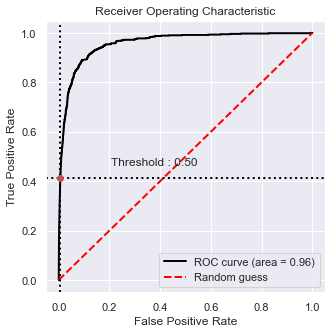

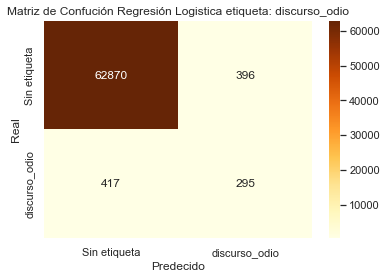

Accuracy is 0.9872925067992122
AUC is 0.9581700831907511
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     63266
           1       0.43      0.41      0.42       712

    accuracy                           0.99     63978
   macro avg       0.71      0.70      0.71     63978
weighted avg       0.99      0.99      0.99     63978

amenaza
Iteration 1, loss = 0.08402669
Iteration 2, loss = 0.01151623
Iteration 3, loss = 0.01056676
Iteration 4, loss = 0.01002621
Iteration 5, loss = 0.00964735
Iteration 6, loss = 0.00926950
Iteration 7, loss = 0.00895518
Iteration 8, loss = 0.00874645
Iteration 9, loss = 0.00845802
Iteration 10, loss = 0.00822933
Iteration 11, loss = 0.00797098
Iteration 12, loss = 0.00787317
Iteration 13, loss = 0.00764953
Iteration 14, loss = 0.00756454
Iteration 15, loss = 0.00732035
Iteration 16, loss = 0.00709735
Iteration 17, loss = 0.00707942
Iteration 18, loss = 0.00689741
Iteration 19, loss = 0.00673089
Iteration

c:\Users\User\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (25) reached and the optimization hasn't converged yet.
  warnings.warn(


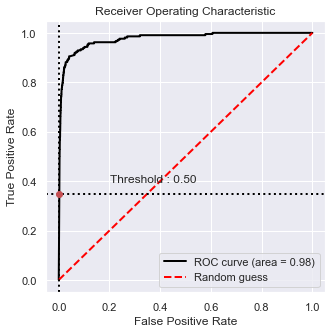

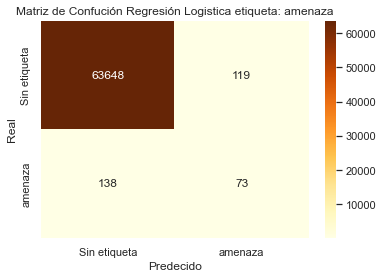

Accuracy is 0.9959829941542405
AUC is 0.9765093400982858
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63767
           1       0.38      0.35      0.36       211

    accuracy                           1.00     63978
   macro avg       0.69      0.67      0.68     63978
weighted avg       1.00      1.00      1.00     63978



In [37]:
accuracy_list2 = []
auc_list2 = []
i=0

for etiqueta in etiquetas:
    print(etiqueta)
    X_p = f_matrix_train
    y = Train_df[etiqueta]
    model[i].fit(X_p, y)

    y_pred_X = model[i].predict(f_matrix_test)
    
    y_test = Test_df[etiqueta]
    test_y_prob = model[i].predict_proba(f_matrix_test)[:,1]

    fpr, tpr, _ = roc_curve(y_test,  test_y_prob)

    accuracy_list2.append(accuracy_score(y_test, y_pred_X))
    auc_list2.append(roc_auc_score(y_test, test_y_prob))
    
    bc = BinaryClassification(y_test, test_y_prob, labels=["Class 1", "Class 2"])
    plt.figure(figsize=(5,5))
    bc.plot_roc_curve()
    plt.show()


    m_LR = confusion_matrix(y_test, y_pred_X)
    sns.heatmap(m_LR,annot=True, cmap="YlOrBr", fmt="d", 
                xticklabels =["Sin etiqueta",  etiqueta], 
                yticklabels = ["Sin etiqueta",  etiqueta])
    plt.ylabel('Real')
    plt.xlabel('Predecido')
    plt.title("Matriz de Confución Regresión Logistica etiqueta: "+ str(etiqueta))
    plt.show()    
    print('Accuracy is {}'.format(accuracy_score(y_test, y_pred_X)))
    print('AUC is {}'.format(roc_auc_score(y_test, test_y_prob)))

    print(classification_report(y_test, y_pred_X))
    i +=1

In [38]:
sum(auc_list2)/len(auc_list2)

ZeroDivisionError: division by zero